In [1]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
# import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import qbstyles
from ing_theme_matplotlib import mpl_style
# import glacierml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/data/T.csv")


#examine data columns
# dataset.head()

2.7.0


# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [2]:
# raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')
raw_dataset = pd.read_csv('~/data/glac/T_models/T.csv')
glathida = raw_dataset.copy()
glathida = glathida.drop([
#                         'GlaThiDa_ID',
#                         'GLACIER_DB',
#                         'GLACIER_ID',
                        'POLITICAL_UNIT',
                        'GLACIER_NAME',
                        'SURVEY_DATE',
                        'MAXIMUM_THICKNESS',
                        'MAX_THICKNESS_UNCERTAINTY',
                        'DATA_FLAG',
                        'ELEVATION_DATE',
                        'SPONSORING_AGENCY',
                        'REMARKS',
                        'SURVEY_METHOD_DETAILS',
                        'SURVEY_METHOD',
                        'NUMBER_OF_SURVEY_POINTS',
                        'NUMBER_OF_SURVEY_PROFILES',
                        'TOTAL_LENGTH_OF_SURVEY_PROFILES',
                        'INTERPOLATION_METHOD',
                        'INVESTIGATOR', 
                        'REFERENCES',
                        'MEAN_THICKNESS_UNCERTAINTY'
                       ], axis=1)
idx = glathida.index[glathida['GLACIER_DB'] == 'RGI']
glathida = glathida.loc[idx]
glathida['GLACIER_ID'] = glathida['GLACIER_ID'].str[6:]
glathida

,GlaThiDa_ID,GLACIER_DB,GLACIER_ID,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
522,2093,RGI,16.00532,-16.302300,-68.106400,0.3097,21.0,22.0
585,2075,RGI,07.00428,78.185100,18.206400,39.9600,3.0,85.0
586,2076,RGI,07.00409,78.107100,17.697800,28.5900,3.0,74.0
595,2085,RGI,10.00353,47.065194,85.563635,3.0780,17.0,23.0
605,2096,RGI,13.31537,38.214000,99.881000,0.5368,24.0,16.0
...,...,...,...,...,...,...,...,...
5128,6619,RGI,01.13696,60.177000,-140.428000,NaN,NaN,NaN
5129,6620,RGI,01.14479,60.691000,-141.391000,NaN,NaN,NaN
5130,6621,RGI,01.14683,60.329000,-141.716000,NaN,NaN,NaN
5131,6622,RGI,01.23641,60.606705,-143.137146,NaN,NaN,NaN


## B. Load and Organize the RGI datasets

In [3]:
# filename = '/home/sa42/data/glac/glims/glims_extra/dump2/07_rgi60_Svalbard.csv'
# with open(filename, 'rb') as file:
#     print(chardet.detect(file.read()))
df = pd.read_csv('/home/sa42/data/glac/glims/glims_extra/dump2/07_rgi60_Svalbard.csv',
                 encoding = 'ISO-8859-1')
RGI_07 = df
RGI_07 = RGI_07.drop([
    'GLIMSId',
    'BgnDate',
    'EndDate',
    'O1Region',
    'O2Region',
    'Status',
    'Connect',
    'Form',
    'TermType',
    'Surging',
    'Linkages',
    'Name',
],axis=1)

df = pd.read_csv('/home/sa42/data/glac/glims/glims_extra/dump2/10_rgi60_NorthAsia.csv',
                 encoding='ISO-8859-1')
RGI_10 = df
RGI_10 = RGI_10.drop([
    'GLIMSId',
    'BgnDate',
    'EndDate',
    'O1Region',
    'O2Region',
    'Status',
    'Connect',
    'Form',
    'TermType',
    'Surging',
    'Linkages',
    'Name',
],axis=1)

with open('/home/sa42/data/glac/glims/glims_extra/dump2/13_rgi60_CentralAsia.csv','r') as temp_f:
# get No of columns in each line
    col_count = [ len(l.split(',')) for l in temp_f.readlines() ]
### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]
### Read csv
df = pd.read_csv('/home/sa42/data/glac/glims/glims_extra/dump2/13_rgi60_CentralAsia.csv',
                 header=None, delimiter=',',names=column_names)
col_names = list(df.iloc[0])
df = pd.read_csv('/home/sa42/data/glac/glims/glims_extra/dump2/13_rgi60_CentralAsia.csv',
                 header=None, delimiter=',', names=col_names)
df.drop(0, inplace=True); df.reset_index(drop=True, inplace=True)
RGI_13 = df
RGI_13 = RGI_13.drop([
    'GLIMSId',
    'BgnDate',
    'EndDate',
    'O1Region',
    'O2Region',
    'Status',
    'Connect',
    'Form',
    'TermType',
    'Surging',
    'Linkages',
    'Name',
],axis=1)

df = pd.read_csv('/home/sa42/data/glac/glims/glims_extra/dump2/16_rgi60_LowLatitudes.csv',
                 encoding='ISO-8859-1')
RGI_16 = df
RGI_16 = RGI_16.drop([
    'GLIMSId',
    'BgnDate',
    'EndDate',
    'O1Region',
    'O2Region',
    'Status',
    'Connect',
    'Form',
    'TermType',
    'Surging',
    'Linkages',
    'Name',
],axis=1)

RGI = pd.concat([RGI_07,RGI_10,RGI_13,RGI_16])
RGI['RGIId'] = RGI['RGIId'].str[6:]
RGI

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,RGIId,CenLon,CenLat,Area,Zmin,Zmax,Zmed,Slope,Aspect,Lmax,NaN
0,07.00001,17.0347,76.7052,0.597,142,459,268,16.7,204,1388,NaN
1,07.00002,16.1891,76.7872,0.581,234,582,343,18.3,277,1658,NaN
2,07.00003,16.3915,76.9194,0.388,157,540,330,19.8,222,1200,NaN
3,07.00004,15.9932,76.9423,1.044,665,933,799,13.8,62,1075,NaN
4,07.00005,16.4966,76.9564,0.5,186,396,263,17.7,35,1068,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2934,16.02941,-74.8539,-11.8971,0.101,4779,5058,4922,33.9,275,405,NaN
2935,16.02942,-78.4438,-0.697071,1.564,4703,5818,5134,28.1,210,2130,NaN
2936,16.02943,-78.4414,-0.670835,0.243,5103,5580,5330,31.5,354,874,NaN
2937,16.02944,-78.428,-0.68772,9.337,4536,5864,5080,26.3,109,2419,NaN


# C. Merge RGI and GlaThiDa along the RGI-ID
The output will include the above GlaThiDa fields, as well as Zmin, Zmax, Zmed, Aspect, and Lmax from RGI

In [5]:
idx = glathida.index[glathida['GLACIER_DB']=='RGI']
glathida = glathida.loc[idx]
glathida.rename(columns = {'GLACIER_ID':'RGIId'},inplace=True)

RGI_glathida = pd.merge(RGI,glathida, how = 'inner', on='RGIId')
RGI_glathida
RGI_glathida = RGI_glathida[[
#  'RGIId',
 'CenLon',
 'CenLat',
 'Area',
 'Zmin',
 'Zmax',
 'Zmed',
 'Slope',
 'Aspect',
 'Lmax',
#  'GlaThiDa_ID',
#  'GLACIER_DB',
 'LAT',
 'LON',
 'AREA',
 'MEAN_SLOPE',
 'MEAN_THICKNESS']]
# RGI_glathida = RGI_glathida.dropna()
RGI_glathida
# RGI_glathida=RGI_glathida.apply(pd.to_numeric)

,CenLon,CenLat,Area,Zmin,Zmax,Zmed,Slope,Aspect,Lmax,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
0,23.5121,79.4014,1095.853,11,666,281,4.4,179,50954,79.4014,23.5121,1095.85300,4.0,NaN
1,23.5121,79.4014,1095.853,11,666,281,4.4,179,50954,79.4014,23.5121,1095.85300,4.0,NaN
2,24.447,79.3657,153.538,28,386,199,3.4,158,18363,79.3657,24.4470,153.53800,3.0,NaN
3,24.5544,79.5931,1226.367,2,767,501,9.0,147,56487,79.5931,24.5544,1226.36700,9.0,NaN
4,24.5544,79.5931,1226.367,2,767,501,9.0,147,56487,79.5931,24.5544,1226.36700,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,97.755000000,39.237000000,2.531,4317,5113,4797,19.2,2,3007,39.2370,97.7550,2.96629,21.0,41.0
368,79.894,41.78,6.595,3802,5698,4598,30.0,194,5814,41.7800,79.8940,1.55417,10.0,29.0
369,84.391,43.731,1.099,3495,3901,3627,17.2,28,1492,43.7310,84.3910,1.24651,20.0,15.0
370,88.356,43.784,6.078,3415,5201,4233,24.7,172,7215,43.7840,88.3560,6.07800,25.0,58.0


### separate out features - what will be trained to predict desired attribute

In [6]:
#split the dataset and reserve some to test what was trained.
train_dataset = RGI_glathida.sample(frac=0.8, random_state=0)
test_dataset = RGI_glathida.drop(train_dataset.index)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop('MEAN_THICKNESS')
test_labels = test_features.pop('MEAN_THICKNESS')
# train_features.describe().transpose()[['mean', 'std']]

In [11]:
# y_tensor = tf.convert_to_tensor(y, dtype=tf.int64) 

# RGI_glathida = pd.to_numeric(RGI_glathida)
RGI_glathida = tf.convert_to_tensor(RGI_glathida, dtype=tf.int64) 
RGI_glathida

ValueError: Tensor conversion requested dtype int64 for Tensor with dtype float64: <tf.Tensor: shape=(372, 14), dtype=float64, numpy=
array([[  23.512,   79.401, 1095.853, ..., 1095.853,    4.   ,      nan],
       [  23.512,   79.401, 1095.853, ..., 1095.853,    4.   ,      nan],
       [  24.447,   79.366,  153.538, ...,  153.538,    3.   ,      nan],
       ...,
       [  84.391,   43.731,    1.099, ...,    1.247,   20.   ,   15.   ],
       [  88.356,   43.784,    6.078, ...,    6.078,   25.   ,   58.   ],
       [ -68.106,  -16.302,    0.649, ...,    0.31 ,   21.   ,   22.   ]])>

# Step 2: Setup the Model

### Establish normalization layers

In [14]:
normalizer = {}
variable_list = (
 'LAT',
 'LON',
 'AREA',
 'MEAN_SLOPE',
#  'MEAN_THICKNESS',
#  'CenLon',
#  'CenLat',
#  'Aspect',
#  'Area',
#  'Zmin',
#  'Zmax',
#  'Zmed',
#  'Slope',
#  'Lmax'
)
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
# normalizer['ALL'].adapt(np.array(train_features))

### Single variable linear regression functions

In [15]:
# glacierml

def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss='mean_absolute_error')
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel('Avg Thickness (m)')
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [16]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [17]:
%%time
for variable_name in variable_list:

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

CPU times: user 2min 25s, sys: 1min 22s, total: 3min 47s
Wall time: 2min 8s


{'LAT': nan, 'LON': nan, 'AREA': nan, 'MEAN_SLOPE': nan}

In [18]:
for variable_name in variable_list:    
    df = pd.DataFrame(linear_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print('')


KeyError: "None of [Index([None], dtype='object')] are in the [index]"

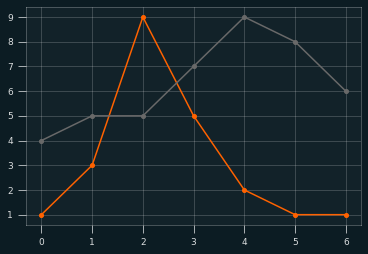

In [22]:
import matplotlib.pyplot as plt
from ing_theme_matplotlib import mpl_style
 
def plot(dark):
  mpl_style(dark)
  plt.plot([1, 3, 9, 5, 2, 1, 1], marker='o')
  plt.plot([4, 5, 5, 7, 9, 8, 6], marker='o')
 
  plt.show()
 
plot(dark=True)

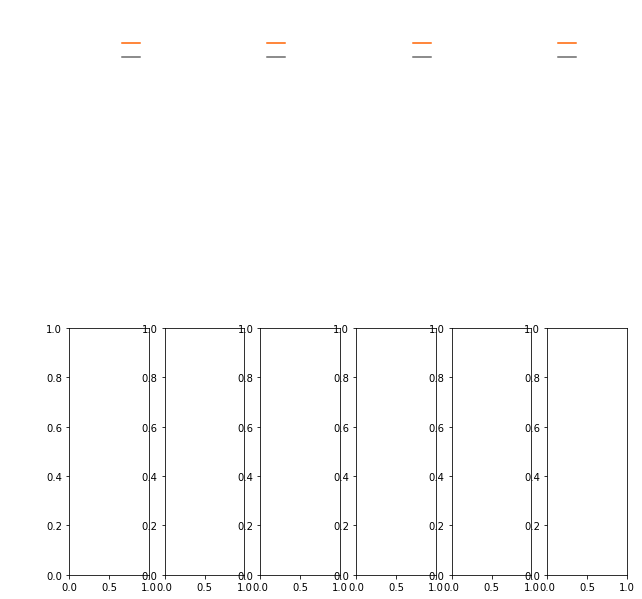

In [21]:
fig,ax=plt.subplots(2,6,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    mpl_style("dark")
    ax = plt.subplot(4,4,i+1)
    plt.subplot(4,4,i+1)
    plot_loss(linear_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [ ]:
linear_model = build_linear_model(normalizer['ALL'])

history_full = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

test_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

In [ ]:
df = pd.DataFrame(history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)



In [ ]:
plot_loss(history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [ ]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [ ]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [ ]:
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

In [ ]:
for variable_name in variable_list:    
    df = pd.DataFrame(dnn_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print('')


In [ ]:
fig,ax=plt.subplots(4,4,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(4,4,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

In [ ]:
fig,ax=plt.subplots(4,4,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(4,4,i+1)
    plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [ ]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [ ]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

In [ ]:
df = pd.DataFrame(dnn_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)


In [ ]:
plot_loss(dnn_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

In [ ]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,200))
plt.ylim((0,200))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")